<a href="https://colab.research.google.com/github/vanderbilt-data-science/MNPSCollaborative/blob/Working-Matrix-Rev-2/MNPS_Eval_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MNPS Practical Evaluation Notebook (Data‑Science Style)

**Purpose:** Evaluate model outputs with simple accuracy gates and cost‑of‑error analysis instead of statistical inference.

- **Keep Section 4 as-is** (your batch inference that writes predictions to CSV).
- **Revised Sections 1–3**: configuration and helpers for the practical evaluation.
- **New Sections 5–7**: error thresholds and cost‑of‑error analysis for Major/Minor role groupings.

---



## 1) Overview & Acceptance Gates (Engineering Style)

We use clear, operational acceptance gates based on what an experienced HR job classification specialist would consider acceptable:

- **Major Role Grouping** acceptable error rate: **≤ 2%** (e.g., Analyst vs. Manager misgroup).
- **Minor Role Grouping** acceptable error rate: **≤ 5%** (e.g., I vs II vs III vs Lead).

We also quantify **severity** via a **cost‑of‑error** analysis:
- For **Major** roles, the cost of an error is the **absolute difference** between the annual values mapped to the *true* vs the *predicted* group.
- For **Minor** roles, the cost of an error is the **absolute difference** between the values mapped to the *true* vs the *predicted* level.

> Rationale: Misclassifying across groups/levels can create pay, equity, and staffing impacts. Using the pay deltas captures the seriousness of the error.



## 2) Config & File Paths

Set your file paths and constants here. **Do not** change class labels unless your data uses a different spelling; these are the canonical labels used in this evaluation.


In [ ]:
#==== Mount Google Drive =======
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# ==== Required file paths (EDIT as needed) ====
#PREDICTIONS_CSV = "data/batch_predictions.csv"  # produced by Section 4 (unchanged)

# ==== Class label vocabularies ====
MAJOR_CLASSES = ["Technician", "Specialist", "Analyst", "Manager", "Coordinator", "Director", "Other"]
MINOR_CLASSES = ["I", "II", "III", "Lead"]

# ==== Acceptance gates ====
ACCEPTABLE_MAJOR_ERROR_RATE = 0.02  # ≤ 2% errors
ACCEPTABLE_MINOR_ERROR_RATE = 0.05  # ≤ 5% errors

# ==== Cost maps (annual $) ====
COST_MAP_MAJOR = {
    "Technician": 54225.00,
    "Specialist": 68765.00,
    "Analyst":   78208.00,
    "Manager":  103904.00,
    "Coordinator": 123133.00,
    "Director": 146246.00,
    "Other":    73780.00,   # If "Other" appears, you can adjust as needed.
}

COST_MAP_MINOR = {
    "I":    4405.00,
    "II":   3366.94,
    "III":  6800.00,
    "Lead": 6800.00,
}

# === Severity of Error (7×7 major grid; rows=true, cols=pred) ===
SEVERITY_MAJOR_GRID = {
    ("Technician","Technician"):0, ("Technician","Specialist"):4, ("Technician","Analyst"):5, ("Technician","Manager"):6, ("Technician","Coordinator"):4, ("Technician","Director"):7, ("Technician","Other"):6,
    ("Specialist","Technician"):4, ("Specialist","Specialist"):0, ("Specialist","Analyst"):4, ("Specialist","Manager"):5, ("Specialist","Coordinator"):3, ("Specialist","Director"):6, ("Specialist","Other"):6,
    ("Analyst","Technician"):5, ("Analyst","Specialist"):4, ("Analyst","Analyst"):0, ("Analyst","Manager"):4, ("Analyst","Coordinator"):4, ("Analyst","Director"):5, ("Analyst","Other"):6,
    ("Manager","Technician"):6, ("Manager","Specialist"):5, ("Manager","Analyst"):4, ("Manager","Manager"):0, ("Manager","Coordinator"):5, ("Manager","Director"):4, ("Manager","Other"):6,
    ("Coordinator","Technician"):4, ("Coordinator","Specialist"):3, ("Coordinator","Analyst"):4, ("Coordinator","Manager"):5, ("Coordinator","Coordinator"):0, ("Coordinator","Director"):6, ("Coordinator","Other"):6,
    ("Director","Technician"):7, ("Director","Specialist"):6, ("Director","Analyst"):5, ("Director","Manager"):4, ("Director","Coordinator"):6, ("Director","Director"):0, ("Director","Other"):6,
    ("Other","Technician"):5, ("Other","Specialist"):5, ("Other","Analyst"):5, ("Other","Manager"):5, ("Other","Coordinator"):5, ("Other","Director"):5, ("Other","Other"):0,
}

# Minor-only severities when majors match: Δ steps {0,1,2,3} → {0,2,3,4}
#MINOR_CLASSES = ["I","II","III","Lead"]  # keep aligned with your list above (already present)
MINOR_IDX = {m:i for i,m in enumerate(MINOR_CLASSES)}

# Optional: severity→cost amplification (toggleable)
APPLY_SEVERITY_MULTIPLIER = True
SEVERITY_COST_MULTIPLIER = {0:0.00, 2:1.15, 3:1.35, 4:1.75, 5:2.50, 6:4.00, 7:6.00}


# ==== Column names expected in predictions CSV ====
# Adjust here if your Section 4 output uses different names.
COL_RECORD_ID   = "record_id"
COL_TRUE_MAJOR  = "true_major_role"
COL_PRED_MAJOR  = "pred_major_role"
COL_TRUE_MINOR  = "true_minor_role"
COL_PRED_MINOR  = "pred_minor_role"

# ==== Output directory ====
OUTPUT_DIR = "artifacts_eval_practical"

# --- Google Drive base for inputs (has spaces; that’s fine) ---
BASE_INPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/Data Inputs"
BASE_INPUT_DIR = "/content/"

# Point to your actual filenames in that folder:
PREDICTIONS_CSV = f"{BASE_INPUT_DIR}/predictions_batch.csv"   # <-- change name if different
# (If you have other inputs, add them too)
# GROUND_TRUTH_CSV = f"{BASE_INPUT_DIR}/ground_truth.csv"
# MAPPINGS_CSV     = f"{BASE_INPUT_DIR}/mappings.csv"




## 3) Helpers

Utility functions for loading data, validating columns, computing confusion matrices, error rates, and cost‑of‑error metrics.


In [ ]:

import os
import math
import json
import pandas as pd
from pathlib import Path

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

def _require_columns(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}. "
                         f"Available: {list(df.columns)}")

def load_predictions(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    _require_columns(df, [COL_RECORD_ID, COL_TRUE_MAJOR, COL_PRED_MAJOR, COL_TRUE_MINOR, COL_PRED_MINOR])
    return df

def confusion(df: pd.DataFrame, true_col: str, pred_col: str, labels: list) -> pd.DataFrame:
    cm = pd.crosstab(df[true_col], df[pred_col], rownames=["True"], colnames=["Pred"], dropna=False)
    # Ensure all labels exist as rows/cols
    cm = cm.reindex(index=labels, columns=labels, fill_value=0)
    return cm

def accuracy_and_error_rate(df: pd.DataFrame, true_col: str, pred_col: str):
    total = len(df)
    correct = (df[true_col] == df[pred_col]).sum()
    acc = correct / total if total > 0 else float('nan')
    err = 1.0 - acc if total > 0 else float('nan')
    return acc, err, correct, total

def cost_of_error_matrix(df: pd.DataFrame, true_col: str, pred_col: str, cost_map: dict, labels: list) -> pd.DataFrame:
    # Build a matrix of summed absolute cost deltas for each (true, pred) pair
    # For correct cells (true==pred), cost is 0.
    cost_pairs = []
    for _, row in df.iterrows():
        t, p = row[true_col], row[pred_col]
        t_cost = cost_map.get(t, 0.0)
        p_cost = cost_map.get(p, 0.0)
        delta = abs(t_cost - p_cost) if (t != p) else 0.0
        cost_pairs.append((t, p, delta))
    cost_df = pd.DataFrame(cost_pairs, columns=["True", "Pred", "CostDelta"])
    pivot = cost_df.pivot_table(index="True", columns="Pred", values="CostDelta", aggfunc="sum", fill_value=0.0)
    pivot = pivot.reindex(index=labels, columns=labels, fill_value=0.0)
    return pivot

def summarize_costs(df: pd.DataFrame, true_col: str, pred_col: str, cost_map: dict):
    # Total and average cost of misclassifications
    mask_wrong = df[true_col] != df[pred_col]
    if mask_wrong.any():
        deltas = (df.loc[mask_wrong, true_col].map(cost_map).fillna(0.0) -
                  df.loc[mask_wrong, pred_col].map(cost_map).fillna(0.0)).abs()
        total_cost = float(deltas.sum())
        avg_cost = float(deltas.mean())
        n_errors = int(mask_wrong.sum())
    else:
        total_cost, avg_cost, n_errors = 0.0, 0.0, 0
    return {
        "n_errors": n_errors,
        "total_cost": total_cost,
        "avg_cost_per_error": avg_cost
    }

def export_csv(df: pd.DataFrame, name: str):
    out = Path(OUTPUT_DIR) / name
    df.to_csv(out, index=True)
    return str(out)

def export_json(obj, name: str):
    out = Path(OUTPUT_DIR) / name
    with open(out, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2)
    return str(out)



In [ ]:
# === Helpers for severity, row costs, and pivoting ===
from pathlib import Path
import numpy as np
import pandas as pd

def minor_delta_severity(true_minor, pred_minor):
    ti = MINOR_IDX.get(str(true_minor), None)
    pi = MINOR_IDX.get(str(pred_minor), None)
    if ti is None or pi is None:
        return 0 if ti == pi else 2
    d = abs(ti - pi)
    return (0, 2, 3, 4)[d] if d <= 3 else 4

def severity_score(true_major, true_minor, pred_major, pred_minor):
    if true_major == pred_major:
        return minor_delta_severity(true_minor, pred_minor)
    return SEVERITY_MAJOR_GRID.get((true_major, pred_major), 0)

def comp_value(major, minor):
    # Composite comp = major base + minor adder (uses your COST_MAPs)
    base = COST_MAP_MAJOR.get(major, COST_MAP_MAJOR.get("Other", 0.0))
    step = COST_MAP_MINOR.get(str(minor), COST_MAP_MINOR["I"])
    return float(base + step)

def sev_multiplier(score):
    return SEVERITY_COST_MULTIPLIER.get(int(score), 1.0)

def add_row_metrics(df):
    # Adds: severity_score, true_comp, pred_comp, cost_base, cost_weighted
    df = df.copy()
    df["severity_score"] = df.apply(lambda r: severity_score(
        r[COL_TRUE_MAJOR], r[COL_TRUE_MINOR], r[COL_PRED_MAJOR], r[COL_PRED_MINOR]
    ), axis=1)
    df["true_comp"] = df.apply(lambda r: comp_value(r[COL_TRUE_MAJOR], r[COL_TRUE_MINOR]), axis=1)
    df["pred_comp"] = df.apply(lambda r: comp_value(r[COL_PRED_MAJOR], r[COL_PRED_MINOR]), axis=1)
    df["cost_base"] = (df["true_comp"] - df["pred_comp"]).abs()
    df["cost_weighted"] = np.where(
        APPLY_SEVERITY_MULTIPLIER,
        df["cost_base"] * df["severity_score"].map(sev_multiplier),
        df["cost_base"]
    )
    return df

def pivot_sum(df, true_col, pred_col, value_col, row_labels, col_labels):
    out = pd.DataFrame(0.0, index=row_labels, columns=col_labels)
    grp = df.groupby([true_col, pred_col], dropna=False)[value_col].sum()
    for (r,c), v in grp.items():
        if r in out.index and c in out.columns:
            out.loc[r, c] = float(v)
    return out

def label28(major, minor):
    # normalize to known labels
    m = major if major in MAJOR_CLASSES else "Other"
    s = str(minor) if str(minor) in MINOR_CLASSES else "I"
    return f"{m} {s}"


## 3.2) Local File Load and Smoke Test

In [ ]:
# Upload your local CSV/XLSX files directly to Colab (one-time per session)
from google.colab import files
import os, shutil, glob

LOCAL_INPUT_DIR = "local_inputs"
os.makedirs(LOCAL_INPUT_DIR, exist_ok=True)

print("Select your files (e.g., ground_truth.csv and/or model_outputs.csv):")
uploaded = files.upload()  # Pick files from your computer

for name in uploaded.keys():
    if os.path.exists(name):
        shutil.move(name, os.path.join(LOCAL_INPUT_DIR, name))

print("\nFiles now in", LOCAL_INPUT_DIR)
for p in sorted(glob.glob(f"{LOCAL_INPUT_DIR}/*")):
    print(" -", p)

# Point the notebook to this folder
BASE_INPUT_DIR = LOCAL_INPUT_DIR


Select your files (e.g., ground_truth.csv and/or model_outputs.csv):


Saving Ground Truth Masterfile (1).csv to Ground Truth Masterfile (1).csv

Files now in local_inputs
 - local_inputs/Ground Truth Masterfile (1).csv
 - local_inputs/Ground Truth Masterfile.csv



## 4) Load Batch Predictions (Section 4 – Unchanged)

This section **expects** that you already ran your existing **Section 4** (batch inference).  
That step should produce a CSV at `PREDICTIONS_CSV` with the following columns:

- `record_id`
- `true_major_role` and `pred_major_role` (values in the set: Technician, Specialist, Analyst, Manager, Coordinator, Director, Other)
- `true_minor_role` and `pred_minor_role` (values in the set: I, II, III, Lead)

> If your column names differ, adjust the constants in Section 2.


In [ ]:
## Section 4 — Load predictions (direct path)
import pandas as pd
preds_start = pd.read_csv(PREDICTIONS_CSV, encoding="latin-1")
print(f"Loaded {len(preds_start):,} predictions from {PREDICTIONS_CSV}")
preds_start.head(3)


Loaded 89 predictions from /content//predictions_batch.csv


,Record_ID,Job Description Name,Position Summary,Education,Work Experience,Essential Functions,Licenses and Certifications,"Knowledge, Skills and Abilities",Original Job Title,New Job Title,Major Role Group,Minor Sub-Group,Borderline Level,Justification
0,1,Spec Routing,Assist in the implementation of all transporta...,High School Diploma or Equivalent Required,1-3 years Experience in pupil transportation a...,Ensure all routes are accurate with critical s...,NaN,Effective written and verbal communication ski...,Spec IT Enterprise Support Network III,IT Enterprise Support Network Specialist III,Specialist,III,NaN,The qualifications for the role do match those...
1,2,Executive Support Specialist,The School Audit Training Specialist designs a...,High School Diploma Required,Minimum of 1 year or more of bookkeeping expe...,Must present and/or train in front of small to...,NaN,Minimum of 1 year or more of experience in a d...,Executive Support Specialist,School Audit Training Assistant I,Assistant,I,NaN,Meets the minimum requirements for an assistan...
2,3,Spec Data Ex Ed,Ensures data integrity and supports the Depart...,High School Diploma or GED Required,1-3 years Applicable experience in database en...,Registers students in SMS for assessments and ...,NaN,"Excellent communication, attention to detail,...",Spec Routing,Routing Specialist I,Specialist,I,NaN,"While the degree requirements are low, only a ..."


### Merge Ground Truth File with Predictions

After we have the output of the model, all we will have are its predictions because a model will normally not have access to the ground truth data.

Here we will leverage the ground truth data that we have access to as developers, combine this with the predictions from the model, and the assess the outputs in later parts of the notebook.

#### Load Ground Truth File

In [ ]:
#===SMOKE TEST====
# --- Section 4A: Create a placeholder predictions CSV from ground truth (smoke test) ---

from pathlib import Path
import pandas as pd

# Point to your labeled truth file on Drive (adjust the name/path)
BASE_INPUT_DIR = LOCAL_INPUT_DIR
TRUTH_CSV      = f"{BASE_INPUT_DIR}/Ground Truth Masterfile.csv"     # <-- CHANGE to your actual file

# Map your truth columns to the expected names below
RECORD_ID_COL  = "Record_ID"          # <-- CHANGE if needed
TRUE_MAJOR_COL = "Major Role Group"    # <-- CHANGE if needed
TRUE_MINOR_COL = "Minor Sub-Group"    # <-- CHANGE if needed

# Try reading with a different encoding
try:
    df_truth = pd.read_csv(TRUTH_CSV, encoding='latin-1')
except UnicodeDecodeError:
    try:
        df_truth = pd.read_csv(TRUTH_CSV, encoding='cp1252')
    except UnicodeDecodeError:
        # If still fails, let the original error propagate
        df_truth = pd.read_csv(TRUTH_CSV)

# Create full column
df_truth['true_major_minor_role'] = df_truth.apply(lambda r: f"{r[TRUE_MAJOR_COL]}-{r[TRUE_MINOR_COL]}", axis=1)

print("Columns in loaded CSV:", list(df_truth.columns))

print("Columns:", list(df_truth.columns))
df_truth.columns = df_truth.columns.str.strip()

Columns in loaded CSV: ['Record_ID', 'Job Description Name', 'Position Summary', 'Education', 'Work Experience', 'Essential Functions', 'Licenses and Certifications', 'Knowledge, Skills and Abilities', 'Original Job Title', 'New Job Title', 'Major Role Group', 'Minor Sub-Group', 'Borderline Level', 'Justification', 'true_major_minor_role']
Columns: ['Record_ID', 'Job Description Name', 'Position Summary', 'Education', 'Work Experience', 'Essential Functions', 'Licenses and Certifications', 'Knowledge, Skills and Abilities', 'Original Job Title', 'New Job Title', 'Major Role Group', 'Minor Sub-Group', 'Borderline Level', 'Justification', 'true_major_minor_role']


In the cell below, we actually create the combined ground truth dataframe. **Note that in this case, the order of the prediction MUST match the order of what is in the ground truth file**.

In [ ]:
# PLACEHOLDER FOR PREDS COLUMN NAMES
# This needs to be set in the output of the prediction file (uncomment later)
#PREDS_MAJOR_COL = "pred_major_role"
#PREDS_MINOR_COL = "pred_minor_role"

# FOR DEBUGGING WITH THE GROUND TRUTH FILE (comment later)
PREDS_MAJOR_COL = TRUE_MAJOR_COL
PREDS_MINOR_COL = TRUE_MINOR_COL

In [ ]:
# Build a perfect (placeholder) predictions file
preds = pd.DataFrame({
    "record_id":        df_truth[RECORD_ID_COL],
    "true_major_role":  df_truth[TRUE_MAJOR_COL],
    "true_minor_role":  df_truth[TRUE_MINOR_COL],
    "true_major_minor_role":  df_truth['true_major_minor_role'],
    "pred_major_role":  preds_start[PREDS_MAJOR_COL],   # same as truth (perfect predictions)
    "pred_minor_role":  preds_start[PREDS_MINOR_COL],
})

# combine true_major_role and true_minor_role together for each row
preds['pred_major_minor_role'] = preds.apply(lambda r: f"{r['pred_major_role']}-{r['pred_minor_role']}", axis=1)

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
PREDICTIONS_CSV = f"{OUTPUT_DIR}/predictions_batch.csv"
preds.to_csv(PREDICTIONS_CSV, index=False)
print("✓ Wrote placeholder predictions to:", PREDICTIONS_CSV)

✓ Wrote placeholder predictions to: artifacts_eval_practical/predictions_batch.csv


### Group all ground truth and predictions into desired categories

,record_id,true_major_role,true_minor_role,pred_major_role,pred_minor_role
0,1,Specialist,III,Specialist,III
1,2,Assistant,I,Assistant,I
2,3,Specialist,I,Specialist,I
3,4,Architect,NaN,Architect,NaN
4,5,Coach,NaN,Coach,NaN
...,...,...,...,...,...
84,85,Clerk,NaN,Clerk,NaN
85,86,Representative,NaN,Representative,NaN
86,87,Advisor,NaN,Advisor,NaN
87,88,Specialist,III,Specialist,III


In [ ]:
#==SANITY CHECK==
# --- Section 4: quick sanity & normalization (run right after loading `preds`) ---
from pathlib import Path

# 1) File exists?
assert Path(PREDICTIONS_CSV).is_file(), f"Predictions CSV not found: {PREDICTIONS_CSV}"

# 2) Required columns present?
required = [COL_RECORD_ID, COL_TRUE_MAJOR, COL_TRUE_MINOR, COL_PRED_MAJOR, COL_PRED_MINOR]
missing = [c for c in required if c not in preds.columns]
if missing:
    raise ValueError(f"Predictions file is missing required column(s): {missing}\n"
                     f"Update the COL_* constants in Section 2 or fix the CSV headers.")

# 3) Normalize text columns (avoids whitespace/type surprises)
for c in [COL_TRUE_MAJOR, COL_TRUE_MINOR, COL_PRED_MAJOR, COL_PRED_MINOR]:
    preds[c] = preds[c].astype(str).str.strip()

# 4) Optional: label-set checks (warns if anything is off-spec)
unknown_true_major = sorted(set(preds[COL_TRUE_MAJOR]) - set(MAJOR_CLASSES))
unknown_pred_major = sorted(set(preds[COL_PRED_MAJOR]) - set(MAJOR_CLASSES))
unknown_true_minor = sorted(set(preds[COL_TRUE_MINOR]) - set(MINOR_CLASSES))
unknown_pred_minor = sorted(set(preds[COL_PRED_MINOR]) - set(MINOR_CLASSES))

if any([unknown_true_major, unknown_pred_major, unknown_true_minor, unknown_pred_minor]):
    print("⚠️ Label check:")
    print("  Unknown TRUE majors:", unknown_true_major)
    print("  Unknown PRED majors:", unknown_pred_major)
    print("  Unknown TRUE minors:", unknown_true_minor)
    print("  Unknown PRED minors:", unknown_pred_minor)

# 5) Peek
print(f"✓ Predictions loaded and validated ({len(preds):,} rows) from {PREDICTIONS_CSV}")
display(preds.head(3))


⚠️ Label check:
  Unknown TRUE majors: ['Accountant', 'Administrative Assistant', 'Advisor', 'Agent', 'Aide', 'Architect', 'Assistant', 'Assistant Principal', 'Auditor', 'Chef', 'Chief', 'Clerk', 'Coach', 'Developer', 'Executive Director', 'Facililtator', 'Liaison', 'Para Professional', 'Representative', 'Teacher', 'Therapist', 'Tutor']
  Unknown PRED majors: ['Accountant', 'Administrative Assistant', 'Advisor', 'Agent', 'Aide', 'Architect', 'Assistant', 'Assistant Principal', 'Auditor', 'Chef', 'Chief', 'Clerk', 'Coach', 'Developer', 'Executive Director', 'Facililtator', 'Liaison', 'Para Professional', 'Representative', 'Teacher', 'Therapist', 'Tutor']
  Unknown TRUE minors: ['II or III', 'nan']
  Unknown PRED minors: ['II or III', 'nan']
✓ Predictions loaded and validated (89 rows) from artifacts_eval_practical/predictions_batch.csv


,record_id,true_major_role,true_minor_role,pred_major_role,pred_minor_role
0,1,Specialist,III,Specialist,III
1,2,Assistant,I,Assistant,I
2,3,Specialist,I,Specialist,I



## 5) Major Role Group Evaluation (Accuracy + Cost of Error)

- Compute Top‑1 accuracy and error rate for **Major** groups.
- Build a **confusion matrix** to see where misgrouping occurs.
- Build a **cost‑of‑error matrix** using the absolute pay delta between true and predicted groups.
- Check against **acceptable error** gate: ≤ 2%.

Exports:
- `confusion_major.csv`
- `cost_matrix_major.csv`
- `metrics_major.json`


Here is just an additional section that may help with calculating the confusion matrix and classification report.

In [ ]:
# Get only the target classes
target_classes_only = MAJOR_CLASSES[:-1]
target_classes_only

# Group other classes into "Other" category
preds['true_major_role'] = preds['true_major_role'].apply(lambda x: 'Other' if x not in target_classes_only else x)
preds['pred_major_role'] = preds['pred_major_role'].apply(lambda x: 'Other' if x not in target_classes_only else x)

              precision    recall  f1-score   support

     Analyst       1.00      1.00      1.00         8
 Coordinator       1.00      1.00      1.00         8
    Director       1.00      1.00      1.00         5
       Other       1.00      1.00      1.00        51
  Specialist       1.00      1.00      1.00        12
  Technician       1.00      1.00      1.00         5

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89



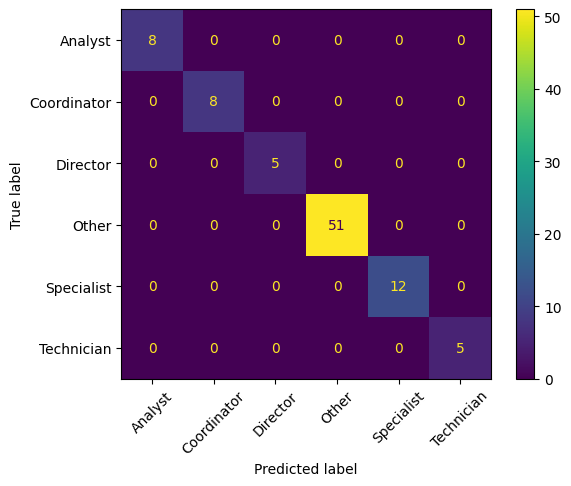

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#full classification report
major_class_report = classification_report(preds[COL_TRUE_MAJOR], preds[COL_PRED_MAJOR])
print(major_class_report)

#confusion matrix
major_confusion_matrix = confusion_matrix(preds[COL_TRUE_MAJOR], preds[COL_PRED_MAJOR])
#print(major_confusion_matrix)

#display pretty confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get list of predicted labels in alphabetical order
pred_labels = sorted(preds[COL_PRED_MAJOR].unique())

# Create a confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=major_confusion_matrix, display_labels=pred_labels)
disp.plot(xticks_rotation=45)
plt.show()

In [ ]:
# Accuracy/error for Major
major_acc, major_err, major_correct, major_total = accuracy_and_error_rate(preds, COL_TRUE_MAJOR, COL_PRED_MAJOR)
major_gate_pass = (major_err <= ACCEPTABLE_MAJOR_ERROR_RATE)

# Confusion for Major
cm_major = confusion(preds, COL_TRUE_MAJOR, COL_PRED_MAJOR, MAJOR_CLASSES)
cm_major_path = export_csv(cm_major, "confusion_major.csv")

# Cost-of-error for Major
cost_major = cost_of_error_matrix(preds, COL_TRUE_MAJOR, COL_PRED_MAJOR, COST_MAP_MAJOR, MAJOR_CLASSES)
cost_major_path = export_csv(cost_major, "cost_matrix_major.csv")

# === Major severity & cost-weighted matrices + 28×28 ===
preds_enriched = add_row_metrics(preds)

# 7×7 (Major) severity and cost
cm_major_sevsum  = pivot_sum(preds_enriched, COL_TRUE_MAJOR, COL_PRED_MAJOR, "severity_score", MAJOR_CLASSES, MAJOR_CLASSES)
cm_major_sevavg  = cm_major_sevsum / cm_major.replace(0, np.nan)

cm_major_costsum = pivot_sum(preds_enriched, COL_TRUE_MAJOR, COL_PRED_MAJOR, "cost_base", MAJOR_CLASSES, MAJOR_CLASSES)
cm_major_costavg = cm_major_costsum / cm_major.replace(0, np.nan)

cm_major_costsum_w = pivot_sum(preds_enriched, COL_TRUE_MAJOR, COL_PRED_MAJOR, "cost_weighted", MAJOR_CLASSES, MAJOR_CLASSES)
cm_major_costavg_w = cm_major_costsum_w / cm_major.replace(0, np.nan)

export_csv(cm_major_sevsum,  "confusion_major_severity_sum.csv")
export_csv(cm_major_sevavg,  "confusion_major_severity_avg.csv")
export_csv(cm_major_costsum, "confusion_major_cost_sum.csv")
export_csv(cm_major_costavg, "confusion_major_cost_avg.csv")
export_csv(cm_major_costsum_w, "confusion_major_cost_sum_weighted.csv")
export_csv(cm_major_costavg_w, "confusion_major_cost_avg_weighted.csv")

# 28×28 labels
preds_enriched["true_28"] = preds_enriched.apply(lambda r: label28(r[COL_TRUE_MAJOR], r[COL_TRUE_MINOR]), axis=1)
preds_enriched["pred_28"] = preds_enriched.apply(lambda r: label28(r[COL_PRED_MAJOR], r[COL_PRED_MINOR]), axis=1)
labels28 = [f"{M} {m}" for M in MAJOR_CLASSES for m in MINOR_CLASSES]

# 28×28 counts use your existing confusion(); build once to reuse for avg
cm_28 = confusion(preds_enriched.rename(columns={"true_28":"__t28","pred_28":"__p28"}), "__t28", "__p28", labels28)

cm_28_sevsum  = pivot_sum(preds_enriched.rename(columns={"true_28":"__t28","pred_28":"__p28"}), "__t28","__p28","severity_score", labels28, labels28)
cm_28_sevavg  = cm_28_sevsum / cm_28.replace(0, np.nan)

cm_28_costsum = pivot_sum(preds_enriched.rename(columns={"true_28":"__t28","pred_28":"__p28"}), "__t28","__p28","cost_base", labels28, labels28)
cm_28_costavg = cm_28_costsum / cm_28.replace(0, np.nan)

cm_28_costsum_w = pivot_sum(preds_enriched.rename(columns={"true_28":"__t28","pred_28":"__p28"}), "__t28","__p28","cost_weighted", labels28, labels28)
cm_28_costavg_w = cm_28_costsum_w / cm_28.replace(0, np.nan)

export_csv(cm_28,             "confusion_major_minor_counts_28x28.csv")
export_csv(cm_28_sevsum,      "confusion_major_minor_severity_sum_28x28.csv")
export_csv(cm_28_sevavg,      "confusion_major_minor_severity_avg_28x28.csv")
export_csv(cm_28_costsum,     "confusion_major_minor_cost_sum_28x28.csv")
export_csv(cm_28_costavg,     "confusion_major_minor_cost_avg_28x28.csv")
export_csv(cm_28_costsum_w,   "confusion_major_minor_cost_sum_weighted_28x28.csv")
export_csv(cm_28_costavg_w,   "confusion_major_minor_cost_avg_weighted_28x28.csv")

# Summaries
cost_summary_major = summarize_costs(preds, COL_TRUE_MAJOR, COL_PRED_MAJOR, COST_MAP_MAJOR)

metrics_major = {
    "accuracy": float(major_acc),
    "error_rate": float(major_err),
    "correct": int(major_correct),
    "total": int(major_total),
    "accept_error_threshold": ACCEPTABLE_MAJOR_ERROR_RATE,
    "pass_gate": bool(major_gate_pass),
    "cost_summary": {
        "n_errors": int(cost_summary_major["n_errors"]),
        "total_cost": float(cost_summary_major["total_cost"]),
        "avg_cost_per_error": float(cost_summary_major["avg_cost_per_error"])
    },
    "artifacts": {
        "confusion_major_csv": cm_major_path,
        "cost_matrix_major_csv": cost_major_path
    }
}


metrics_major_path = export_json(metrics_major, "metrics_major.json")
print("Major accuracy:", round(major_acc*100, 2), "%")
print("Major error rate:", round(major_err*100, 2), "%", "| PASS gate:", major_gate_pass)
print("Major cost (total): ${:,.2f} | avg per error: ${:,.2f}".format(
    metrics_major["cost_summary"]["total_cost"],
    metrics_major["cost_summary"]["avg_cost_per_error"],
))
display(cm_major)

Major accuracy: 100.0 %
Major error rate: 0.0 % | PASS gate: True
Major cost (total): $0.00 | avg per error: $0.00


Pred,Technician,Specialist,Analyst,Manager,Coordinator,Director,Other
True,,,,,,,
Technician,5,0,0,0,0,0,0
Specialist,0,12,0,0,0,0,0
Analyst,0,0,8,0,0,0,0
Manager,0,0,0,0,0,0,0
Coordinator,0,0,0,0,8,0,0
Director,0,0,0,0,0,5,0
Other,0,0,0,0,0,0,0



## 6) Minor Role Group Evaluation (Accuracy + Cost of Error)

- Compute Top‑1 accuracy and error rate for **Minor** levels (I, II, III, Lead).
- Build a **confusion matrix**.
- Build a **cost‑of‑error matrix** using the absolute value difference between true and predicted levels.
- Check against **acceptable error** gate: ≤ 5%.

Exports:
- `confusion_minor.csv`
- `cost_matrix_minor.csv`
- `metrics_minor.json`


Let's start by calculating the confusion matrix and classification report.

              precision    recall  f1-score   support

           I       1.00      1.00      1.00        13
          II       1.00      1.00      1.00         9
   II or III       1.00      1.00      1.00         3
         III       1.00      1.00      1.00         6
        Lead       1.00      1.00      1.00         1
         nan       1.00      1.00      1.00        57

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89



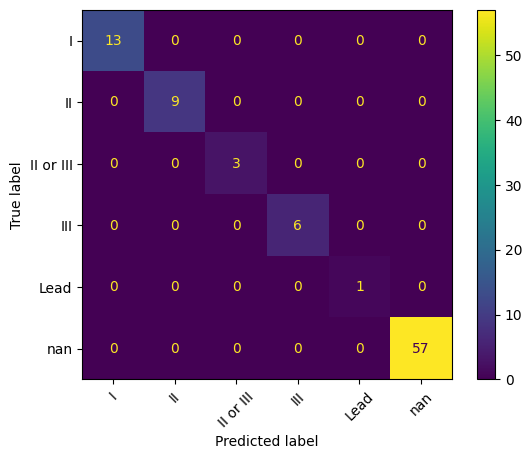

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#full classification report
minor_class_report = classification_report(preds[COL_TRUE_MINOR], preds[COL_PRED_MINOR])
print(minor_class_report)

#confusion matrix
minor_confusion_matrix = confusion_matrix(preds[COL_TRUE_MINOR], preds[COL_PRED_MINOR])

# Get list of predicted labels in alphabetical order
pred_labels = sorted(preds[COL_PRED_MINOR].unique())

# Create a confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=minor_confusion_matrix, display_labels=pred_labels)
disp.plot(xticks_rotation=45)
plt.show()

In [ ]:
# Accuracy/error for Minor
minor_acc, minor_err, minor_correct, minor_total = accuracy_and_error_rate(preds, COL_TRUE_MINOR, COL_PRED_MINOR)
minor_gate_pass = (minor_err <= ACCEPTABLE_MINOR_ERROR_RATE)

# Confusion for Minor
cm_minor = confusion(preds, COL_TRUE_MINOR, COL_PRED_MINOR, MINOR_CLASSES)
cm_minor_path = export_csv(cm_minor, "confusion_minor.csv")

# Cost-of-error for Minor
cost_minor = cost_of_error_matrix(preds, COL_TRUE_MINOR, COL_PRED_MINOR, COST_MAP_MINOR, MINOR_CLASSES)
cost_minor_path = export_csv(cost_minor, "cost_matrix_minor.csv")

# Summaries
cost_summary_minor = summarize_costs(preds, COL_TRUE_MINOR, COL_PRED_MINOR, COST_MAP_MINOR)

metrics_minor = {
    "accuracy": float(minor_acc),
    "error_rate": float(minor_err),
    "correct": int(minor_correct),
    "total": int(minor_total),
    "accept_error_threshold": ACCEPTABLE_MINOR_ERROR_RATE,
    "pass_gate": bool(minor_gate_pass),
    "cost_summary": {
        "n_errors": int(cost_summary_minor["n_errors"]),
        "total_cost": float(cost_summary_minor["total_cost"]),
        "avg_cost_per_error": float(cost_summary_minor["avg_cost_per_error"])
    },
    "artifacts": {
        "confusion_minor_csv": cm_minor_path,
        "cost_matrix_minor_csv": cost_minor_path
    }
}

metrics_minor_path = export_json(metrics_minor, "metrics_minor.json")
print("Minor accuracy:", round(minor_acc*100, 2), "%")
print("Minor error rate:", round(minor_err*100, 2), "%", "| PASS gate:", minor_gate_pass)
print("Minor cost (total): ${:,.2f} | avg per error: ${:,.2f}".format(
    metrics_minor["cost_summary"]["total_cost"],
    metrics_minor["cost_summary"]["avg_cost_per_error"],
))
display(cm_minor)

# === Minor-only severity summaries (optional but parallel) ===
# Here, severity is purely the minor delta (since we’re evaluating minor-level quality)
preds_minor = preds_enriched.copy()
#cm_minor = confusion(preds_minor, COL_TRUE_MINOR, COL_PRED_MINOR, MINOR_CLASSES)

# Minor severity (sum/avg) where majors match or not; still informative at minor level
preds_minor["minor_severity_only"] = preds_minor.apply(
    lambda r: minor_delta_severity(r[COL_TRUE_MINOR], r[COL_PRED_MINOR]), axis=1
)

cm_minor_sevsum = pivot_sum(preds_minor, COL_TRUE_MINOR, COL_PRED_MINOR, "minor_severity_only", MINOR_CLASSES, MINOR_CLASSES)
cm_minor_sevavg = cm_minor_sevsum / cm_minor.replace(0, np.nan)


export_csv(cm_minor_sevsum, "confusion_minor_severity_sum.csv")
export_csv(cm_minor_sevavg, "confusion_minor_severity_avg.csv")

Minor accuracy: 100.0 %
Minor error rate: 0.0 % | PASS gate: True
Minor cost (total): $0.00 | avg per error: $0.00


Pred,I,II,III,Lead
True,,,,
I,13,0,0,0
II,0,9,0,0
III,0,0,6,0
Lead,0,0,0,1


'artifacts_eval_practical/confusion_minor_severity_avg.csv'


## 7) Summary & Review Queue

Creates a compact summary of gates and surfaces the most **costly** errors for quick human review.


In [ ]:
# =========================
# Section 7 — Summary, KPI, and Review Queues
# =========================
import pandas as pd

# --- KPI: Severity-Weighted Cost Index (SWCI) ---
mask_mis = preds_enriched["severity_score"] > 0
total_weighted_cost = float(preds_enriched.loc[mask_mis, "cost_weighted"].sum())
total_payroll       = float(preds_enriched["true_comp"].sum())
n_records           = int(len(preds_enriched))
mis_rate            = float(mask_mis.mean())

# $ per $1M payroll (lower is better) and per 1,000 predictions companion
SWCI       = (1_000_000.0 * total_weighted_cost) / max(total_payroll, 1.0)
SWCI_per_1k = (1_000.0 * total_weighted_cost) / max(n_records, 1)

print("=== Severity-Weighted Cost Index ===")
print(f"SWCI (per $1M payroll):         ${SWCI:,.0f}")
print(f"Total severity-weighted cost:    ${total_weighted_cost:,.0f}")
print(f"Total payroll represented:       ${total_payroll:,.0f}")
print(f"Misclassification rate:          {mis_rate:.2%}")
print(f"Companion: cost per 1,000 preds: ${SWCI_per_1k:,.0f}")
print(f"Records evaluated:               {n_records:,}")

# Persist KPI
summary_metrics = {
    "SWCI_per_$1M": SWCI,
    "SWCI_per_1000_predictions": SWCI_per_1k,
    "total_severity_weighted_cost": total_weighted_cost,
    "total_payroll": total_payroll,
    "misclassification_rate": mis_rate,
    "records": n_records,
    "severity_multiplier_enabled": bool(APPLY_SEVERITY_MULTIPLIER),
}
export_json(summary_metrics, "summary_metrics.json")

# --- Build overall summary (include KPI) ---
summary = {
    "major": metrics_major,
    "minor": metrics_minor,
    "gates": {
        "major_pass": metrics_major["pass_gate"],
        "minor_pass": metrics_minor["pass_gate"],
    },
    "kpi": {
        "SWCI_per_$1M": SWCI,
        "SWCI_per_1000_predictions": SWCI_per_1k
    }
}
summary_path = export_json(summary, "summary_overview.json")

# --- Review queues ---
def _error_rows_with_cost(df, true_col, pred_col, cost_map, tag):
    mask = df[true_col] != df[pred_col]
    if not mask.any():
        return pd.DataFrame(columns=["record_id", "true", "pred", "cost_delta", "dimension"])
    t_cost = df.loc[mask, true_col].map(cost_map).fillna(0.0)
    p_cost = df.loc[mask, pred_col].map(cost_map).fillna(0.0)
    d = (t_cost - p_cost).abs()
    out = pd.DataFrame({
        "record_id": df.loc[mask, COL_RECORD_ID],
        "true":      df.loc[mask, true_col],
        "pred":      df.loc[mask, pred_col],
        "cost_delta": d,
        "dimension": tag
    })
    return out

# Base review (cost delta) — keep this
err_major = _error_rows_with_cost(preds, COL_TRUE_MAJOR, COL_PRED_MAJOR, COST_MAP_MAJOR, "major")
err_minor = _error_rows_with_cost(preds, COL_TRUE_MINOR, COL_PRED_MINOR, COST_MAP_MINOR, "minor")
review = pd.concat([err_major, err_minor], ignore_index=True)
review = review.sort_values("cost_delta", ascending=False).head(200).reset_index(drop=True)
review_path = export_csv(review, "errors_sampled_for_review.csv")

# Severity-weighted review (NEW) — ranks by severity-weighted $ impact
review_sw = review.merge(
    preds_enriched[[COL_RECORD_ID, "cost_weighted"]],
    left_on="record_id",
    right_on=COL_RECORD_ID,
    how="left"
).rename(columns={"cost_weighted": "severity_weighted_cost"})

review_sw = review_sw.sort_values(["severity_weighted_cost", "cost_delta"],
                                  ascending=False).head(200).reset_index(drop=True)
review_sw_path = export_csv(review_sw, "errors_sampled_for_review_severity_weighted.csv")

print("Summary written to:", summary_path)
print("Review (base cost) written to:", review_path)
print("Review (severity-weighted) written to:", review_sw_path)
display(review_sw.head(10))


=== Severity-Weighted Cost Index ===
SWCI (per $1M payroll):         $0
Total severity-weighted cost:    $0
Total payroll represented:       $7,600,510
Misclassification rate:          0.00%
Companion: cost per 1,000 preds: $0
Records evaluated:               89
Summary written to: artifacts_eval_practical/summary_overview.json
Review (base cost) written to: artifacts_eval_practical/errors_sampled_for_review.csv
Review (severity-weighted) written to: artifacts_eval_practical/errors_sampled_for_review_severity_weighted.csv


,record_id,true,pred,cost_delta,dimension,severity_weighted_cost


## **8) Copies Results to Google Drive Folder**
Copies the run results to a google drive folder

In [ ]:
!cp -r '/content/artifacts_eval_practical' '/content/drive/My Drive/Colab Notebooks/Run Results'